# Including

In [3]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using ProgressMeter
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Aharonov-Bohm Phase.ipynb");

# Model Parameters

$\phi=\frac{p}{q}=\frac{p}{N_y}, N_\phi=\phi NxNy=N_x \text{ (The number of single particle degeneracy)}$

In [4]:
Nx=7
Ny=10
N=Nx*Ny
p=1
q=10
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [0, 1, 2, 3]
U = 4;

Nx=10
Ny=10
N=Nx*Ny
p=1
q=2
NPhi = Int( Nx * Ny * (p/q) )
cut_off = Nx
PN = [0, 1, 2, 3]
U = 4;
Bu set için GS dejenere gelmedi ve quasi-hole pinlenmedi. GS dejenere katlılığının çok büyük olması ile ilgisi var mı?

# Sub Space Kinetic Term

In [5]:
function H_sp(N, Nx, Ny, p, q)
    sp_basis = NLevelBasis(N)
    periodicity = 0 #periodic (select 1 for hard-wall conditions)
    sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity)
    H1 = get_sp_op(sp_basis, sp_matrix)
    return H1, sp_basis
end

H_sp (generic function with 1 method)

In [7]:
H1, sp_basis = H_sp(N, Nx, Ny, p, q);

In [53]:
eigenenergies(dense(H1))

70-element Vector{Float64}:
 -3.4200536414081686
 -3.4200392067500944
 -3.420039206750087
 -3.420006767541715
 -3.4200067675417145
 -3.419980748488536
 -3.419980748488536
 -2.3522286356942845
 -2.3522286356942836
 -2.3517196016250934
 -2.351719601625093
 -2.351082916372103
 -2.351082916372103
  ⋮
  2.351082916372102
  2.3517196016250903
  2.3517196016250934
  2.352228635694282
  2.352228635694285
  3.4199807484885336
  3.4199807484885367
  3.4200067675417167
  3.4200067675417176
  3.420039206750093
  3.420039206750096
  3.4200536414081677

In [8]:
(1/4)*2*pi

1.5707963267948966

In [9]:
H1.data
angle((H1.data)[11,12])+angle((H1.data)[15,11])+angle((H1.data)[16,15])+angle((H1.data)[12,16])-(2*pi)

-5.654866776461628

In [10]:
mod(angle((H1.data)[15,16])+angle((H1.data)[3,15])+angle((H1.data)[4,3])+angle((H1.data)[16,4]), 2*pi)

5.026548245743669

In [11]:
mod(angle((H1.data)[8,12])+angle((H1.data)[9,12])+angle((H1.data)[5,9])+angle((H1.data)[8,5]),2*pi)

0.0

In [12]:
mod(angle((H1.data)[13,16])+angle((H1.data)[1,13])+angle((H1.data)[4,1])+angle((H1.data)[16,4]),2*pi)

0.0

In [13]:
3*pi/2

4.71238898038469

In [14]:
(1/4)*2*pi

1.5707963267948966

In [15]:
lattice, coordinates = square_lattice(Nx,Ny)    
coordinates

70×2 transpose(::Matrix{Any}) with eltype Any:
 0  0
 1  0
 2  0
 3  0
 4  0
 5  0
 6  0
 0  1
 1  1
 2  1
 3  1
 4  1
 5  1
 ⋮  
 2  8
 3  8
 4  8
 5  8
 6  8
 0  9
 1  9
 2  9
 3  9
 4  9
 5  9
 6  9

In [16]:
# coords[1,1]
exp(2*pi*im*(p/q)*Ny*(coordinates[1,1]+Nx))

1.0 - 1.7145055188062944e-15im

In [17]:
16/3

5.333333333333333

In [18]:
angle((H1.data)[13,16]),angle((H1.data)[1,13]),angle((H1.data)[4,1]),angle((H1.data)[16,4])

(0.0, 0.0, 0.0, 0.0)

In [19]:
angle((H1.data)[16,13])

0.0

In [20]:
function H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis)
    sub_states = get_sub_states(H1, cut_off)
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
    H1_sub = get_subspace_op(H1, P, Pt)
    return H1_sub, basis_sub, P, Pt
end

H_sub (generic function with 1 method)

In [21]:
H1_sub, basis_sub, P, Pt = H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis);

In [22]:
Nx

7

In [23]:
function H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    states_mb = bosonstates(basis_sub, PN) 
    basis_mb = ManyBodyBasis(basis_sub, states_mb)
    H1_MB = get_mb_op(basis_mb, H1_sub)
    return H1_MB
end

H_Kin_MB (generic function with 1 method)

In [24]:
Nx

7

In [25]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [26]:
Nx

7

In [27]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off, PN)

(ManyBody(onebodybasis=NLevel(N=7), states:120), NLevel(N=7))

In [28]:
function H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb)
    H_Kin = SparseOperator(basis_cut_mb)
    H1_MB = H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    H_Kin.data = H1_MB.data
    H_Int = Hubbard_Interaction_op(P, Pt, basis_cut_mb, cut_off, U)
    return H_Kin, H_Kin + H_Int
end

H_Total_Sub (generic function with 1 method)

# Sub Space Hubbard Interaction Term

In [29]:
H_Kin, Total_H = H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb);

# Total Hamiltonian with Impurity Potential

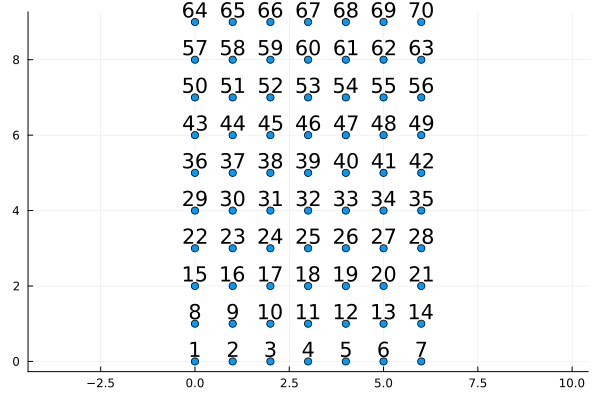

([0 0; 1 0; … ; 5 9; 6 9], nothing)

In [30]:
plot_square_lattice(Nx, Ny)

For particle pinning: V0<0 & PN = 1, U = 0!

In [31]:
V0 = [4]; Imp_Site = [39]
Impurity_Data = Impurity(V0, Imp_Site);

In [32]:
function Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub)
    num_sub_list = get_num_sub_list(N, sp_basis, P, Pt)
    Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)
    return Sub_Number_MB_Operator_List
end

Number_sub (generic function with 1 method)

In [33]:
Sub_Number_MB_Operator_List = Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub);

In [34]:
function get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = dense((H_Impurity'+H_Impurity)/2);
    return H_Impurity
end

get_H_Impurity (generic function with 1 method)

In [35]:
H_Impurity = get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data)

Operator(dim=120x120)
  basis: ManyBody(onebodybasis=NLevel(N=7), states:120)
 0.0+0.0im           0.0+0.0im          …          0.0+0.0im
 0.0+0.0im      -3.42004+0.0im                     0.0+0.0im
 0.0+0.0im   0.000325501+0.000120955im             0.0+0.0im
 0.0+0.0im   0.000250859+0.000268234im             0.0+0.0im
 0.0+0.0im  -0.000256388-0.001033im                0.0+0.0im
 0.0+0.0im    0.00131015+0.000616075im  …          0.0+0.0im
 0.0+0.0im   -4.77737e-5-1.62686e-5im              0.0+0.0im
 0.0+0.0im   -4.13345e-5-4.39396e-6im              0.0+0.0im
 0.0+0.0im           0.0+0.0im                     0.0+0.0im
 0.0+0.0im           0.0+0.0im                     0.0+0.0im
 0.0+0.0im           0.0+0.0im          …          0.0+0.0im
 0.0+0.0im           0.0+0.0im                     0.0+0.0im
 0.0+0.0im           0.0+0.0im                     0.0+0.0im
    ⋮                                   ⋱  
 0.0+0.0im           0.0+0.0im             -9.05232e-5-0.000682398im
 0.0+0.0im      

In [36]:
# SP IMPURITY

In [37]:
# VV = zeros(Nx*Ny,Nx*Ny)
# site = Impurity_Data.Imp_Site[1]
# VV[site, site] = Impurity_Data.V0[1] # full localised single particle
# VV = Operator(sp_basis,sp_basis,VV);

In [38]:
# H_imp_SP = H1 + VV;

In [39]:
# sub_states = get_sub_states(H_imp_SP, cut_off)
# basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
# H_imp_sp_sub = get_subspace_op(H_imp_SP, P, Pt)
# H_imp_sp_sub = (H_imp_sp_sub' + H_imp_sp_sub)/2;

In [40]:
# E_sp_sub, V_sp_sub = eigenstates(H_imp_sp_sub);
# scatter(E_sp_sub)

\begin{align*}
    &\text{Filling fraction:} \quad \nu=\frac{N}{N_{\Phi}} = \frac{3}{8}, \quad \text{Laughlin fraction: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles. One of them is pinned.}
\end{align*}

# Exact Diagonalization

In [42]:
N_Pin = 1

1

In [43]:
function ground_degeneracy(N_Pin, nu0, PN)
    NPhi0 = Nx*Ny*(p/q)
    NPhi = NPhi0-N_Pin
    pn = maximum(PN)
    N_d = Int(NPhi - pn/nu0)
    Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))
    return Degeneracy
end

ground_degeneracy (generic function with 1 method)

In [44]:
if length(PN) != 1
    nu0 = 1/2
    Degeneracy = ground_degeneracy(N_Pin, nu0, PN)
else
    Degeneracy = 1
end

2

In [45]:
Degeneracy

2

In [46]:
E_no_filt, V_no_filt = eigenstates(H_Impurity);
E_no_filt

120-element Vector{Float64}:
 -10.25969927005493
 -10.259504388703398
 -10.192772794021021
 -10.188669081050131
 -10.188454640314216
 -10.16594864850884
 -10.130268799630828
 -10.113491923001053
 -10.113371016917933
 -10.113241017849578
 -10.100916972205567
 -10.100217004387089
 -10.092966982425684
   ⋮
  -6.349983534656871
  -6.323051217060327
  -6.238216858511812
  -5.8437865142395875
  -3.4200536405220094
  -3.4200392067500927
  -3.4200368300425694
  -3.420006767541715
  -3.4199807817249965
  -3.419980748488538
  -3.0218876247831647
   0.0

In [47]:
function energies_imp(H_Impurity, PN, basis_cut_mb)
    E, V = eigenstates(H_Impurity)
    pn = maximum(PN)
    filtered_energies = get_filtered_energies(pn, E, V, basis_cut_mb)
    return filtered_energies, V
end

energies_imp (generic function with 1 method)

In [48]:
# PN = 1 İken (AB faz hesaplarken) sadece bir parçacık var o yüzden filter yapmayacağız!!!

In [49]:
filtered_energies, V = energies_imp(H_Impurity, PN, basis_cut_mb);

In [50]:
filtered_energies

84-element Vector{Float64}:
 -10.25969927005493
 -10.259504388703398
 -10.192772794021021
 -10.188669081050131
 -10.188454640314216
 -10.16594864850884
 -10.130268799630828
 -10.113491923001053
 -10.113371016917933
 -10.113241017849578
 -10.100916972205567
 -10.100217004387089
 -10.092966982425684
   ⋮
  -9.464758867422209
  -9.458742303335823
  -9.414009768701158
  -9.412581343659628
  -9.338032242954768
  -9.255873428715569
  -9.212732142420391
  -9.202200838260149
  -9.074894850702815
  -9.017810984465308
  -8.856528145366074
  -8.465736598917838

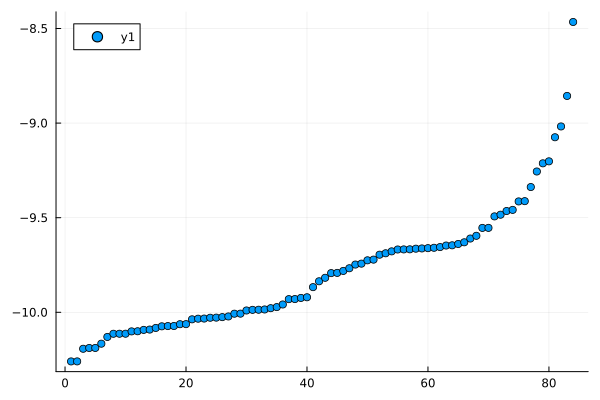

In [51]:
scatter(filtered_energies)

In [144]:
# Onur hocanın makalesinde ki FIG1 çıktısı

# using Plots
# using LaTeXStrings
# Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
# #ylims!((-7.20544,-7.20536))

Alltaki fonksiyonun çalışması için, dizideki filtre edilmiş parçacık sayısı her zaman en büyük değerde olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

# Density Profile

In [145]:
filtered_energies;

In [146]:
r_hubbard_states = Restricted_Hubbard_States(V, filtered_energies);

In [147]:
function plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
    avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)
    return Plots.heatmap(Interp(avg_density', factor), aspect_ratio=:equal)
end

plot_density (generic function with 1 method)

In [148]:
avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states);

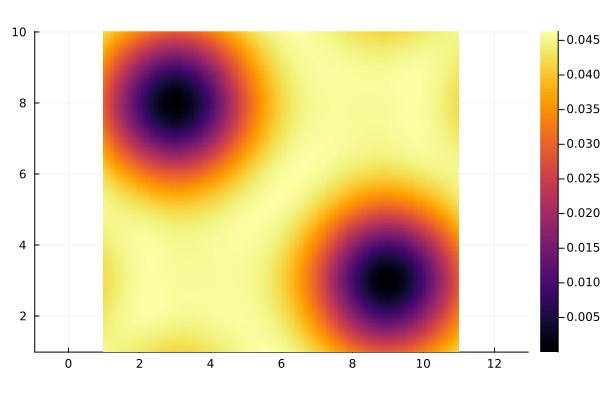

In [149]:
factor = 25
plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
#scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N], :bottom), legend=false)

# Braiding and AB Phase Calculations

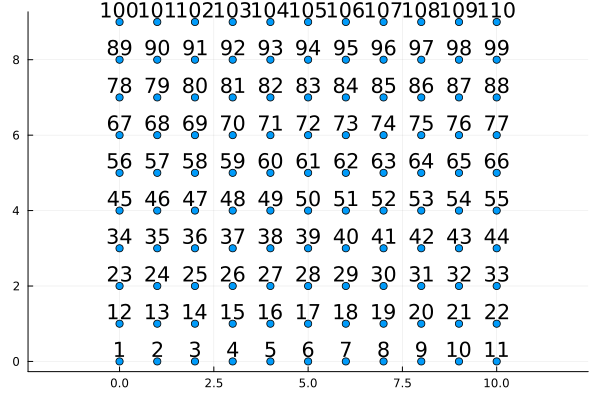

([0 0; 1 0; … ; 9 9; 10 9], nothing)

In [150]:
plot_square_lattice(Nx, Ny)

In [153]:
start_point_1 = Impurity_Data.Imp_Site[1]

80

In [154]:
lens_1 = [5, 5, 5, 5]
dirs_1 = [1, Nx, -1, -Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))
rec_path_1 = push!(rec_path_1,start_point_1)

21-element Vector{Int64}:
  80
  81
  82
  83
  84
  85
  96
 107
 118
 129
 140
 139
 138
 137
 136
 135
 124
 113
 102
  91
  80

In [155]:
rec_path_1 = [31,42,53,64,75,86,97,108,9,20,31,30,29,28,27,26,25,24,23,33,32,31,20,9,108,97,86,75,64,53,42,31,32,33,23,24,25,26,27,28,29,30,31]

43-element Vector{Int64}:
  31
  42
  53
  64
  75
  86
  97
 108
   9
  20
  31
  30
  29
   ⋮
  31
  32
  33
  23
  24
  25
  26
  27
  28
  29
  30
  31

In [156]:
start_point_2 = Impurity_Data.Imp_Site[2]

31

In [157]:
lens_2 = [5, 5, 5, 5]
dirs_2 = [-1, -Nx, 1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
rec_path_2 = push!(rec_path_2,start_point_2)

21-element Vector{Int64}:
  31
  30
  29
  28
  27
  26
  15
   4
  -7
 -18
 -29
 -28
 -27
 -26
 -25
 -24
 -13
  -2
   9
  20
  31

In [158]:
rec_path_2 = repeat([80],length(rec_path_1))

43-element Vector{Int64}:
 80
 80
 80
 80
 80
 80
 80
 80
 80
 80
 80
 80
 80
  ⋮
 80
 80
 80
 80
 80
 80
 80
 80
 80
 80
 80
 80

In [159]:
N_Pin = 4 # Burada ki N_Pin ile yukarıda tanımladığımız N_Pin farklılar!
V1 = Impurity_Data.V0[1]
V2 = 0;
V2 = Impurity_Data.V0[2]

4.0

In [160]:
Imp_Site = [rec_path_1[1], rec_path_1[2], rec_path_2[1], rec_path_2[2]]
V0 = [V1, 0, V2, 0]
Impurity_Data = Impurity(V0, Imp_Site);

In [161]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [162]:
E_Imp_0, U_Imp_0 = eigenstates(Impurity_H)
U_Imp_0 = hcat([U_Imp_0[i].data for i in 1:Degeneracy] ...);

In [163]:
U_first = copy(U_Imp_0);

In [164]:
delta_t = 0.01
STEP = 0:delta_t:1
length(STEP)

101

In [165]:
Imp_Site_List = [ [imp, rec_path_1[idx+1], rec_path_2[idx], rec_path_2[idx+1] ] for (idx,imp) in (enumerate(rec_path_1[1:end-1])) ]
V0_List = [ [V1*(1-step), V1*step, V2*(1-step), V2*step] for step in STEP ];

In [166]:
Impurity_Data_List = [ [Impurity(V00, Imp_Sitee)] for Imp_Sitee in Imp_Site_List for V00 in V0_List ];

In [167]:
Impurity_H_List = [ Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Dataa[1]) for Impurity_Dataa in ProgressBar(Impurity_Data_List) ];

0.0%┣                                            ┫ 0/4.2k [00:00<00:-47, -0s/it]
0.1%┣                                             ┫ 4/4.2k [00:00<01:28, 48it/s]
0.3%┣▏                                          ┫ 14/4.2k [00:00<00:37, 115it/s]
0.6%┣▎                                          ┫ 26/4.2k [00:00<00:28, 153it/s]
0.9%┣▍                                          ┫ 39/4.2k [00:00<00:24, 173it/s]
1.2%┣▌                                          ┫ 51/4.2k [00:00<00:23, 182it/s]
1.5%┣▋                                          ┫ 63/4.2k [00:00<00:22, 191it/s]
1.8%┣▊                                          ┫ 76/4.2k [00:00<00:21, 197it/s]
2.1%┣▉                                          ┫ 87/4.2k [00:00<00:21, 198it/s]
2.4%┣█                                         ┫ 100/4.2k [00:00<00:20, 204it/s]
2.7%┣█▏                                        ┫ 113/4.2k [00:01<00:20, 206it/s]
2.9%┣█▎                                        ┫ 124/4.2k [00:01<00:20, 207it/s]
3.2%┣█▍                     

In [168]:
function U_Imp_0_Ket(U_Imp_0)
    Eigen_List = []
    U_IMP_0_List = []
    for Impurity_HH in ProgressBar(Impurity_H_List)
        Impurity_HH = dense((Impurity_HH+Impurity_HH')/2)
        E_Imp, U_Imp = eigenstates(Impurity_HH)
        push!(Eigen_List, U_Imp)
        U_Imp = hcat([U_Imp[i].data for i in 1:Degeneracy] ...)
        A = U_Imp_0'*U_Imp
        A_inv = inv(A)
        U_Imp_0 = U_Imp*A_inv
        # for i in 1:Degeneracy
        #     Norm_0 = sqrt(U_Imp_0[:,i]'*U_Imp_0[:,i])
        #     U_Imp_0[:,i] = U_Imp_0[:,i] ./ Norm_0
        # end
        #global U_Imp_0 = gram_schmidt(U_Imp_0)
    end
    return U_Imp_0, Eigen_List, U_IMP_0_List
end

U_Imp_0_Ket (generic function with 1 method)

In [169]:
U_Imp_0, Eigen_List, U_IMP_0_List = U_Imp_0_Ket(U_Imp_0);

0.0%┣                                             ┫ 0/4.2k [00:00<00:00, -0s/it]
0.0%┣                                         ┫ 1/4.2k [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 2/4.2k [00:01<52:39, 1it/s]
0.1%┣                                              ┫ 3/4.2k [00:01<38:46, 2it/s]
0.1%┣                                              ┫ 4/4.2k [00:01<33:25, 2it/s]
0.1%┣                                              ┫ 5/4.2k [00:02<30:59, 2it/s]
0.1%┣                                              ┫ 6/4.2k [00:02<29:22, 2it/s]
0.2%┣                                              ┫ 7/4.2k [00:02<28:35, 2it/s]
0.2%┣                                              ┫ 8/4.2k [00:03<27:45, 3it/s]
0.2%┣                                              ┫ 9/4.2k [00:03<27:10, 3it/s]
0.2%┣                                             ┫ 10/4.2k [00:03<26:45, 3it/s]
0.3%┣▏                                            ┫ 11/4.2k [00:04<26:24, 3it/s]
0.3%┣▏                      

LoadError: InterruptException:

In [94]:
BerryEnergies, BerryStates = eigen(U_Imp_0' * U_first)
Θ = angle.(BerryEnergies)/(2*pi)

16-element Vector{Float64}:
  0.47050135314143243
  0.45638753886777417
  0.3840581400201296
  0.34881073666871903
 -0.22436827577510876
  0.1978068309322983
 -0.1908526451663348
 -0.19062213835222588
 -0.17506088986434531
 -0.17233452778660097
  0.1667941862220435
  0.16296628366806126
 -0.14550665046597522
 -0.10242453217523323
  0.025934834343103275
 -0.012090244277653189

In [95]:
sum(Θ)

1.0000000000000837

In [96]:
Degeneracy

16

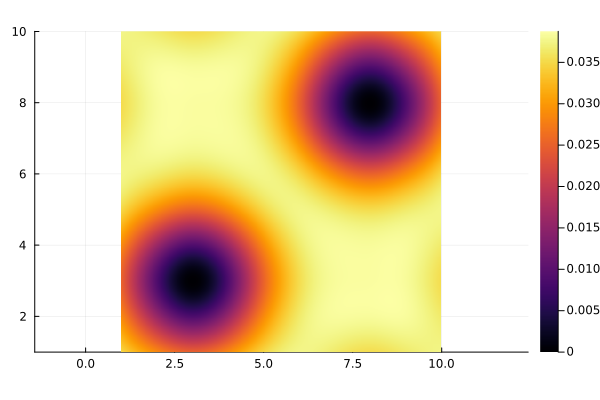

In [93]:
data1 = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[1])'
heatmap(Interp(data1, 100), aspect_ratio=:equal)

# Single Particle Brading with Tanh Potential

In [57]:
# Not: Kodun başında ki parametreler SP için OLMALI!

In [58]:
# co = vcat( ( [y x] for x in 0:Ny-1 for y in 0:Nx-1 ) ... );

In [59]:
# plot_square_lattice(Nx, Ny)

In [60]:
# x0, y0 = co[18,:]
# x1, y1 = co[20,:]
# x2, y2 = co[48,:]
# x3, y3 = co[46,:]
# coord = [x0, y0, x1, y1, x2, y2, x3, y3];

In [61]:
# mutable struct impurity
#     V0::Float64
#     pos::Array{Float64}
#     wid::Float64
# end

In [62]:
# V0 = 10
# wid = 0.1
# imps = [impurity(V0, [x0,y0], wid) ];

In [63]:
# function Vpin2(imp, N, co)
#     VV   = zeros(N,N)
#     for site in 1:N
#         VV[site, site] = imp.V0*(tanh( norm( co[site,:] - imp.pos ) / imp.wid )^2 -1)
#     end
#     return VV
# end

In [64]:
# function Vimp2(imps, N, co)
#     VM   = zeros(N,N)
#     for imp in imps 
#         VM +=  Vpin2(imp, N, co)
#     end
#     return VM
# end

In [65]:
# function Himp(imps, N, co, basis, H1)
#     VimpM = Vimp2(imps, N, co)
#     Vimp_op = get_sp_op(basis, VimpM)
#     return H1 + Vimp_op
# end

In [66]:
# H1_tanh = Himp(imps, N, co, sp_basis, H1);

In [67]:
# E_0, U_0 = eigenstates(dense(H1_tanh));

In [68]:
# θ, ψ_list = get_ab_phase2(coord, 0.1, V0, wid, N, co, sp_basis, H1, U_0, Degeneracy);

In [69]:
# θ